In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import sys
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.models as models

from PIL import Image
import warnings

# disable warnings
Image.MAX_IMAGE_PIXELS = None # image processing
# auto-reload functions before each instance running them
%load_ext autoreload
%autoreload 2

In [2]:
# Remote instance set-up cell
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [3]:
# directory setup cell
repo = 'tree-finder/'
location = 'google'

# Local paths
local_root = '/Users/etriesch/dev/'
colab_root = '/content/drive/My Drive/git/'
aws_root = '/home/ec2-user/'

# define root
if location == 'local':
    root = local_root
elif location == 'google':
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    root = colab_root
elif location == 'aws':
    root = aws_root

repo_path = root + repo
model_path = repo_path + 'models/'
data_path = repo_path + 'data/'
sys.path.append(repo_path)

Mounted at /content/drive


In [4]:
# setup cell
from notebooks.plot_fns import show_image_batch, set_plt_settings, plot_accs
from notebooks.train_fns import flatten, Flatten, train_model
from notebooks.models import ResnetBinClassifier, ResnetTransferClassifier
from notebooks.data_processing import define_transforms, make_dataloaders, IMAGE_DIM, MEAN, STD

set_plt_settings()

# Make dataset and loaders
This includes augmenting my dataset

In [ ]:
# define transformations
transforms = define_transforms(scale_up=1024, crop=1024, scale_out=IMAGE_DIM, mean=MEAN, std=STD, mirror=True, randomcrop=True)

# create dataset by concatenating all transformations
binds = []
for t in transforms:
    df = dset.ImageFolder(root=data_path + 'images_bin', transform=transforms[t])
    binds.append(df)

binds = ConcatDataset(binds)
class_names = binds.datasets[0].classes
print('class names:', class_names)

# make dataloaders
dataloaders, ds_sizes = make_dataloaders(dataset=binds, subset=None, test_split=0.10, val_split=0.25, sampleN=8, batch_size=32, seed=None)

class names: ['nottree', 'tree']
dataloader sizes: {'all': 10400, 'train': 7020, 'validate': 2340, 'test': 1040, 'sampler': 8}


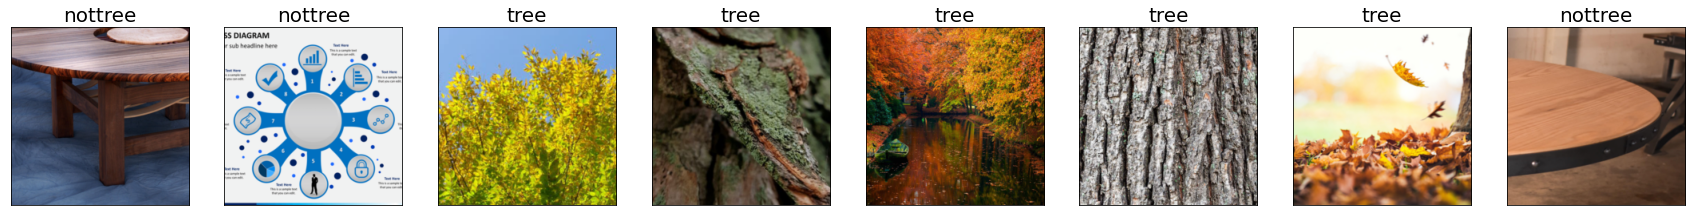

In [ ]:
# visualize images
samp_input, samp_class = next(iter(dataloaders['sampler']))

# print(type(imgs), type(labels))
show_image_batch(samp_input, mean=MEAN, std=STD, 
                 title=[class_names[x] for x in samp_class])

# Retrain a pretrained model for binary classification of trees

## Overfit on small data

In [ ]:
# small_data_train_size = 500
# small_data_validate_size = 100
# small_batch_size = 25
# small_loaders = {}
# small_loaders['train'] = DataLoader(binds, batch_size=small_batch_size,
#                            sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(binds), small_data_train_size)))
# small_loaders['validate'] = DataLoader(binds, batch_size=small_batch_size,
#                            sampler=sampler.SubsetRandomSampler(np.random.randint(0, len(binds), small_data_validate_size)))
# small_ds_sizes = {'train':small_data_train_size, 'validate':small_data_validate_size}

# define small loader for testing
random_idxs = np.random.choice(range(len(treeds)), 500).tolist()
small_loaders, small_ds_sizes = make_dataloaders(
    dataset=treeds, subset=random_idxs, test_split=0.01, val_split=0.25, 
    sampleN=4, batch_size=20, seed=1)

In [ ]:
model = ResnetBinClassifier(resnet50=False)
model = model.to(device)
print(model.get_grad_state())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler_lr = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) #lr decay

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

loading pretrained resnet18...
{'unfrozen': ['fc'], 'frozen': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']}


In [ ]:
acc_history = train_model(model, criterion, optimizer, scheduler_lr,
                          small_loaders, small_ds_sizes, device, 2)
plot_accs({key: acc_history[key] for key in ['epoch_train', 'epoch_validate']})

## Train using entire dataset

In [ ]:
model = ResnetTransferClassifier(num_classes=2, retrain_last_cnblock=False)
model = model.to(device)
print(model.get_grad_state())
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True)
scheduler_lr = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1) # lr decay

loading pretrained resnet50...
{'unfrozen': ['fc'], 'frozen': ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool']}


In [ ]:
acc_history = train_model(model, criterion, optimizer, scheduler_lr,
                                   dataloaders, ds_sizes, device, 4)
plot_accs({key: acc_history[key] for key in ['epoch_train', 'epoch_validate']})
torch.save(model.state_dict(), model_path / 'ResnetBinClassifier.pt')

  0%|          | 0/220 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
train epoch: [1/4] Loss: 0.2206 ACC@1: 94.48%:  82%|████████▏ | 181/220 [53:20<12:34, 19.35s/it]

In [ ]:
# print scores for sample of images
scores = model(samp_input)
percentage = F.softmax(scores, dim=1) * 100
# print trees and score for detecting tree for a random sample of images
tree_likelihood = percentage[:,1].detach().numpy()
show_image_batch(samp_imgs.cpu(), MEAN, STD, title=tree_likelihood)

In [ ]:
# git saver cell
if location == 'google':
    %cd '/content/drive/My Drive /git/tree-finder'
    !git config --global user.email "erich.j.trieschman@gmail.com"
    !git config --global user.name "Erich Trieschman"

    !git add .
    !git commit -m 'rerun pretrained model'
    !git push

/content/drive/My Drive /git/tree-finder
[main 6f2b38a] rerun pretrained model
 4 files changed, 4 insertions(+), 4 deletions(-)
 rewrite notebooks/preprocess_images.ipynb (78%)
 rewrite notebooks/scrape_trees.ipynb (98%)
 rewrite notebooks/train_binary_tree_classifier.ipynb (90%)
 rewrite notebooks/train_species_classifiers.ipynb (98%)
Counting objects: 7, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 3.68 KiB | 77.00 KiB/s, done.
Total 7 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/etrieschman/tree-finder
   e2b477f..6f2b38a  main -> main
